# Exploration of the aviable data

In [1]:
import os
import random

import numpy as np
import pandas as pd
import scipy.sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns

# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

## Load data

In [2]:
item_type = pd.read_csv(
    "data/data_ICM_type.csv",
    usecols=["item_id", "feature_id"],
    dtype={0: "Int64", 1: "Int64"},
).set_index("item_id")
item_length = pd.read_csv(
    "data/data_ICM_length.csv",
    usecols=["item_id", "data"],
    dtype={0: "Int64", 1: "Int64"},
).set_index("item_id")
item_length = item_length.rename(columns={"data": "length"})
interactions = pd.read_csv(
    "data/interactions_and_impressions.csv",
    dtype={0: "Int64", 1: "Int64", 2: str, 3: "Int64"},
)
interactions = interactions.rename(
    columns={
        "UserID": "user_id",
        "ItemID": "item_id",
        "Data": "data",
        "Impressions": "impressions",
    }
)
target_users = pd.read_csv(
    "data/data_target_users_test.csv",
    usecols=["user_id"],
    dtype={0: "Int64"},
)
views = interactions[interactions["data"] == 0].drop(["data", "impressions"], axis=1)
details = interactions[interactions["data"] == 1].drop(["data", "impressions"], axis=1)
print("item_type", item_type.shape)
print("item_length", item_length.shape)
print("interactions", interactions.shape)
print("views", views.shape)
print("details", details.shape)


item_type (23091, 1)
item_length (23091, 1)
interactions (5826506, 4)
views (3567479, 2)
details (2259027, 2)


## Exploration

- The length of most shows is low (1, 2, 3)
- There are a lot of possible lengths, most of them are unique

C:\Users\basso\AppData\Local\Temp\ipykernel_3300\481590916.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  most_common_lengths = item_length["length"].value_counts()[:30]


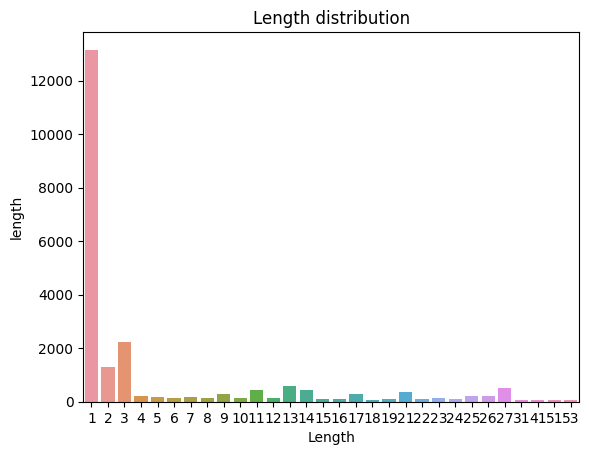

In [3]:
most_common_lengths = item_length["length"].value_counts()[:30]
plt.title("Length distribution")
plt.xlabel("Length")
plt.ylabel("Count")
sns.barplot(x=most_common_lengths.index, y=most_common_lengths)
plt.show()


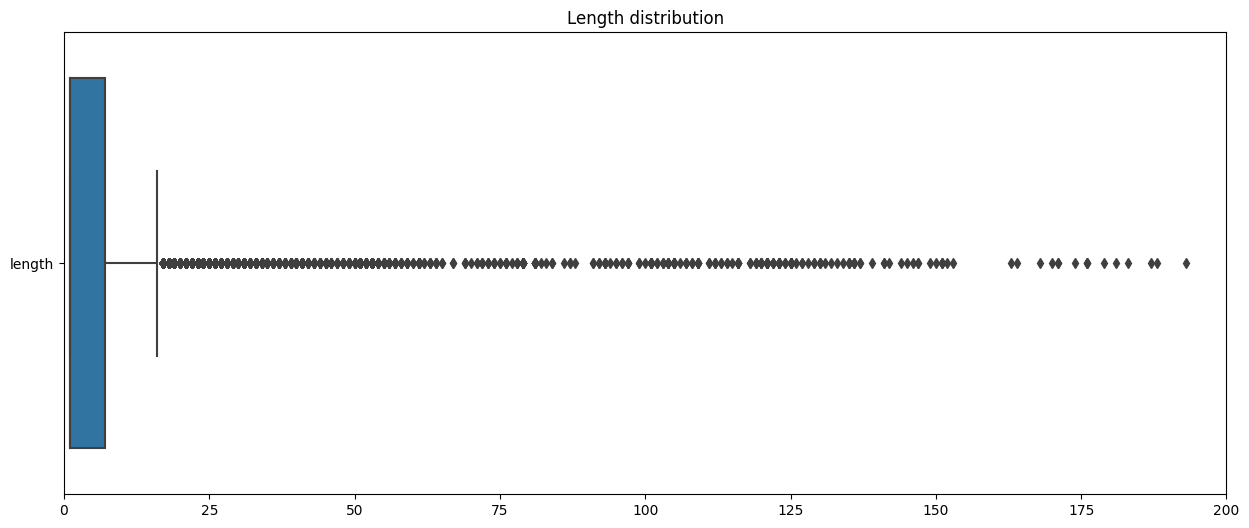

In [4]:
plt.figure(figsize=(15, 6))
plt.title("Length distribution")
sns.boxplot(data=item_length[["length"]], orient="h")
plt.xlim(0, 200)
plt.show()

There are a lot of utilers:

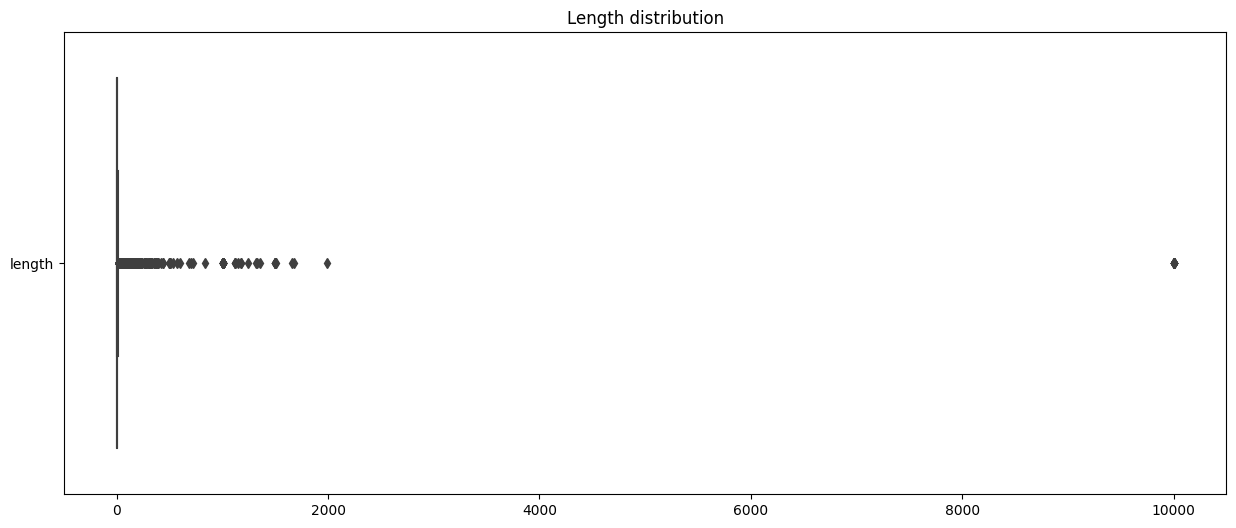

In [5]:
plt.figure(figsize=(15, 6))
plt.title("Length distribution")
sns.boxplot(data=item_length[["length"]], orient="h")
plt.show()

In [6]:
print(
    f'{np.around(item_length.loc[item_length["length"] > 100].shape[0] / item_length.shape[0] *100, 4)}% of the lengths are above 100'
)


1.3035% of the lengths are above 100


We can replace this outliers with the most common length value (1):

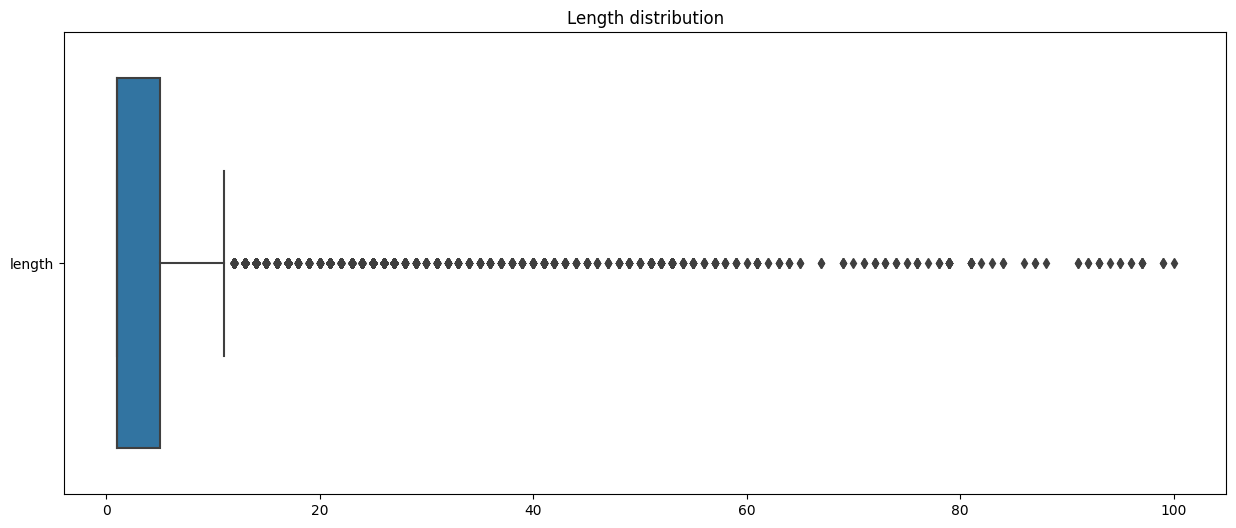

In [7]:
item_length.loc[item_length["length"] > 100, "length"] = 1
plt.figure(figsize=(15, 6))
plt.title("Length distribution")
sns.boxplot(data=item_length[["length"]], orient="h")
plt.show()

- The types are imbalanced
- There are no shows of type 5 and 6, and only five shows of type 7
- Most of the shows are of type 1

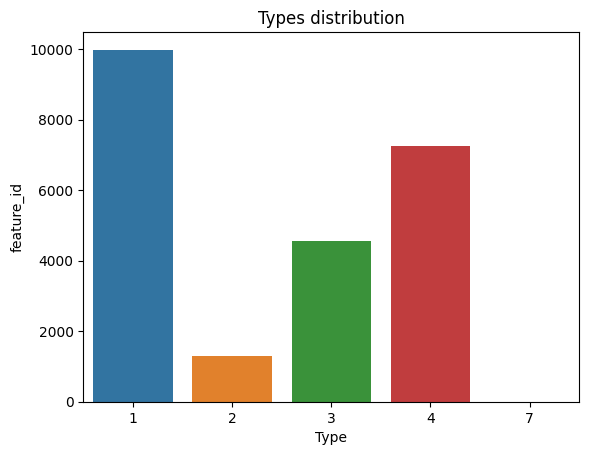

In [8]:
plt.title("Types distribution")
plt.xlabel("Type")
plt.ylabel("Count")
sns.barplot(
    x=item_type["feature_id"].value_counts().sort_index().index,
    y=item_type["feature_id"].value_counts().sort_index(),
)
plt.show()


- There is some dependence from type and length
- Type 4 has a longer length than the others
- Type 1, 2, 3 have a short length

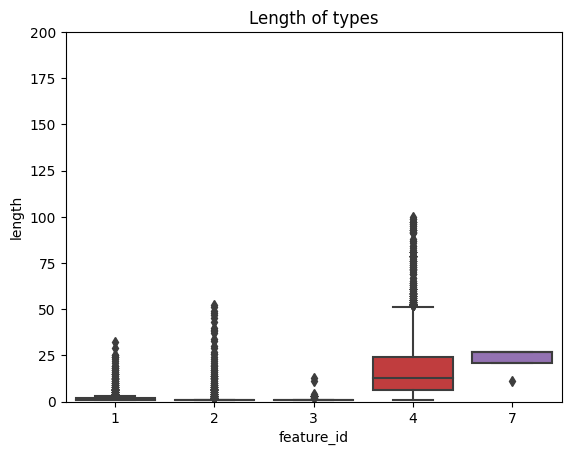

In [9]:
type_length = item_length.join(item_type)
plt.title("Length of types")
plt.xlabel("Type")
plt.ylabel("Length")
sns.boxplot(data = type_length, x = "feature_id", y = "length")
plt.ylim(0, 200)
plt.show()

Build a table (user_id, item_id, views_count, details_count, length, feature_id):

In [10]:
views["views_count"] = 1
views_count = views.groupby(["user_id", "item_id"], as_index = False)["views_count"].sum()
details["details_count"] = 1
details_count = details.groupby(["user_id", "item_id"], as_index = False)["details_count"].sum()

view_details_count = views_count.set_index(['user_id', 'item_id']).join(
    details_count.set_index(['user_id', 'item_id']), on=["user_id", "item_id"], how='outer'
)
view_details_count.loc[view_details_count['details_count'].isna(), 'details_count'] = 0
view_details_count.loc[view_details_count['views_count'].isna(), 'views_count'] = 0
view_details_count = view_details_count.join(item_length, on="item_id")
view_details_count = view_details_count.join(item_type, on="item_id")
view_details_count = view_details_count.reset_index()
view_details_count

,user_id,item_id,views_count,details_count,length,feature_id
0,0,21,3.0,9.0,27.0,4
1,0,124,1.0,0.0,3.0,1
2,0,808,1.0,0.0,1.0,1
3,0,1326,1.0,3.0,3.0,1
4,0,1995,1.0,2.0,17.0,4
...,...,...,...,...,...,...
1554635,41628,11228,0.0,1.0,30.0,4
1554636,41628,15033,0.0,1.0,1.0,3
1554637,41628,15181,0.0,1.0,8.0,4
1554638,41628,20896,0.0,1.0,NaN,<NA>


Set missing type and length to 1 (most common value)

In [11]:
view_details_count.loc[view_details_count["feature_id"].isna(), "feature_id"] = 1
view_details_count.loc[view_details_count["length"].isna(), "length"] = 1

Calculate the views ratio and details ratio using the length:

In [12]:
view_details_count["views_ratio"] = view_details_count["views_count"]/view_details_count["length"]
view_details_count["details_ratio"] = view_details_count["details_count"]/view_details_count["length"]
view_details_count.head()

,user_id,item_id,views_count,details_count,length,feature_id,views_ratio,details_ratio
0,0,21,3.0,9.0,27.0,4,0.111111,0.333333
1,0,124,1.0,0.0,3.0,1,0.333333,0.000000
2,0,808,1.0,0.0,1.0,1,1.000000,0.000000
3,0,1326,1.0,3.0,3.0,1,0.333333,1.000000
4,0,1995,1.0,2.0,17.0,4,0.058824,0.117647


Views and details are similarly distributed:

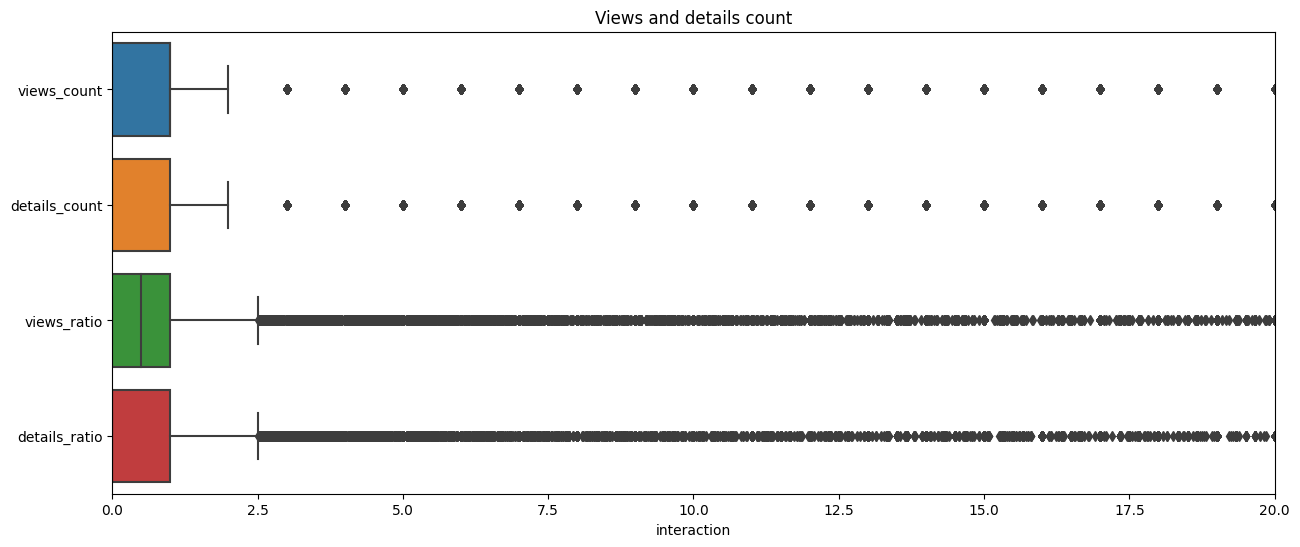

In [13]:
plt.figure(figsize=(15, 6))
plt.title("Views and details count")
plt.xlabel("interaction")
sns.boxplot(
    data=view_details_count[
        ["views_count", "details_count", "views_ratio", "details_ratio"]
    ],
    orient="h",
)
plt.xlim(0, 20)
plt.show()


There are a lot of utliers:

1.907% of the views_count are above 25
2.1548% of the views_count are above 25


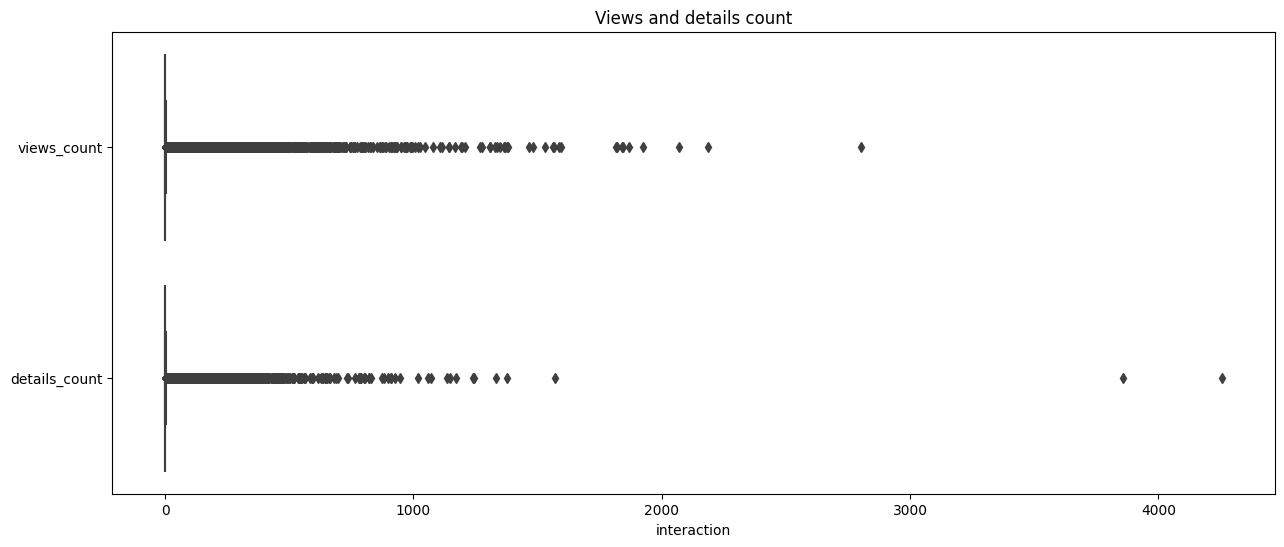

In [14]:
print(
    f'{np.around(view_details_count.loc[view_details_count["views_count"] > 25].shape[0] / view_details_count.loc[view_details_count["views_count"] > 0].shape[0] *100, 4)}% of the views_count are above 25'
)
print(
    f'{np.around(view_details_count.loc[view_details_count["details_count"] > 25].shape[0] / view_details_count.loc[view_details_count["details_count"] > 0].shape[0] *100, 4)}% of the views_count are above 25'
)

plt.figure(figsize=(15, 6))
plt.title("Views and details count")
plt.xlabel("interaction")
sns.boxplot(
    data=view_details_count[
        ["views_count", "details_count"]
    ],
    orient="h",
)
plt.show()


We can remove the outliers:

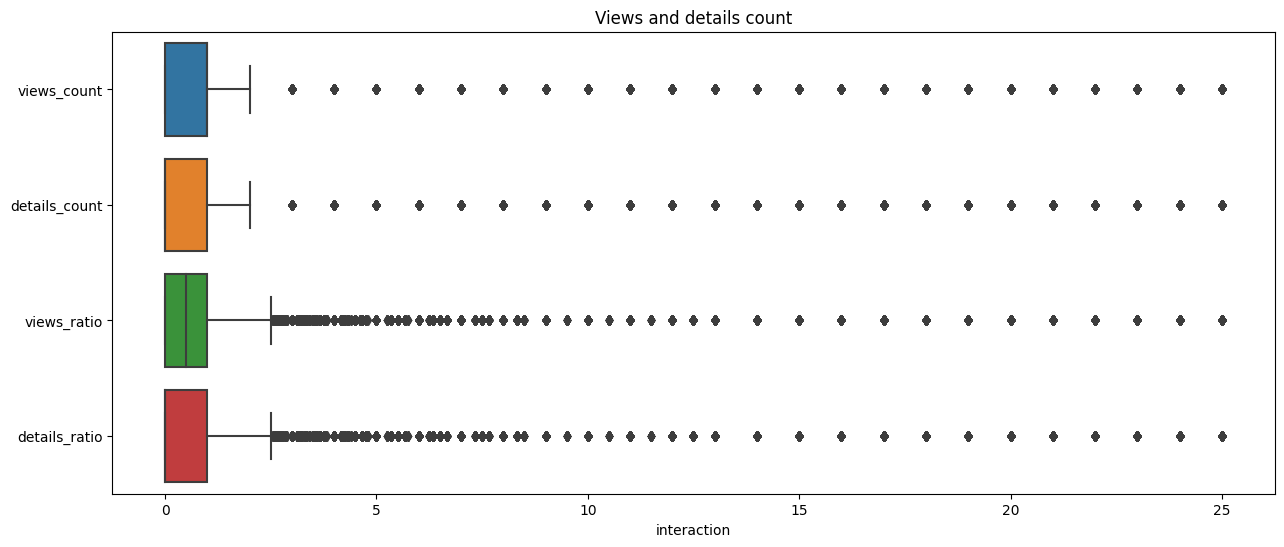

In [15]:
view_details_count.loc[view_details_count["views_count"] > 25, "views_count"] = 25
view_details_count.loc[view_details_count["details_count"] > 25, "details_count"] = 25
view_details_count["views_ratio"] = view_details_count["views_count"]/view_details_count["length"]
view_details_count["details_ratio"] = view_details_count["details_count"]/view_details_count["length"]
plt.figure(figsize=(15, 6))
plt.title("Views and details count")
plt.xlabel("interaction")
sns.boxplot(
    data=view_details_count[
        ["views_count", "details_count", "views_ratio", "details_ratio"]
    ],
    orient="h",
)
plt.show()

Standardize:

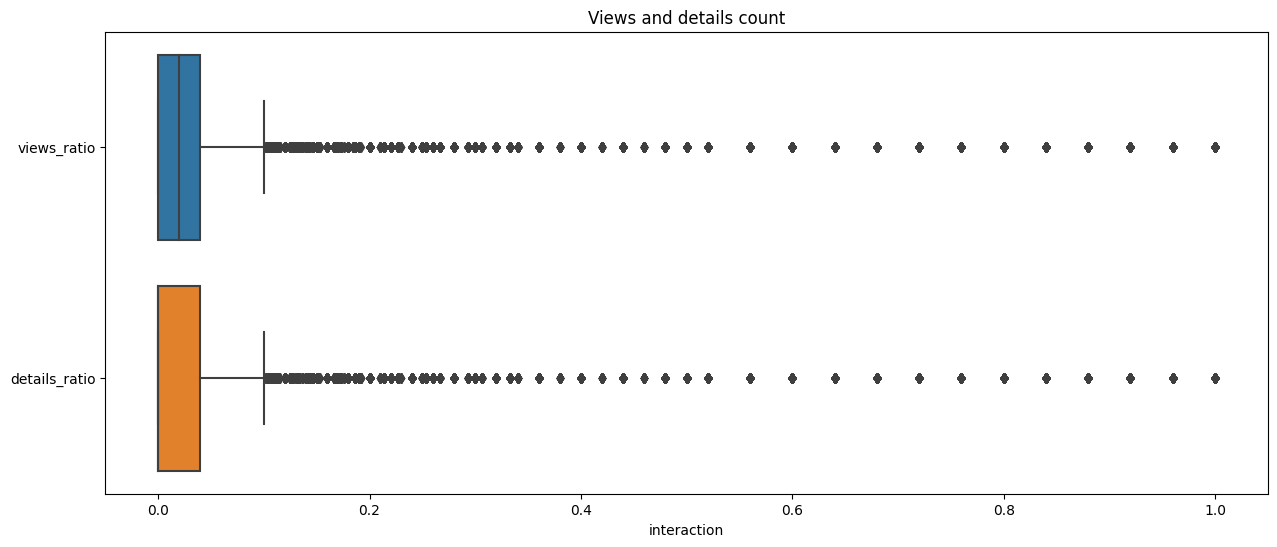

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
view_details_count[["views_ratio", "details_ratio"]] = scaler.fit_transform(view_details_count[["views_ratio", "details_ratio"]])
plt.figure(figsize=(15, 6))
plt.title("Views and details count")
plt.xlabel("interaction")
sns.boxplot(
    data=view_details_count[
        ["views_ratio", "details_ratio"]
    ],
    orient="h",
)
plt.show()

## Build and save URM splits

In [17]:
view_details_count["views_ratings"] = view_details_count["views_count"] / (view_details_count["views_count"] + 0.1 * view_details_count["length"])
view_details_count["details_ratings"] = view_details_count["details_count"] / (view_details_count["details_count"] + 0.1 * view_details_count["length"])
view_details_count["combined_ratings"] = 0.9*view_details_count["views_ratings"] + 0.1*view_details_count["details_ratings"]
#view_details_count["ratings"] = view_details_count["views_ratio"] + 0.1*view_details_count["details_ratio"]

ratings_scaler = MinMaxScaler()
#view_details_count[["combined_ratings"]] = ratings_scaler.fit_transform(view_details_count[["combined_ratings"]])


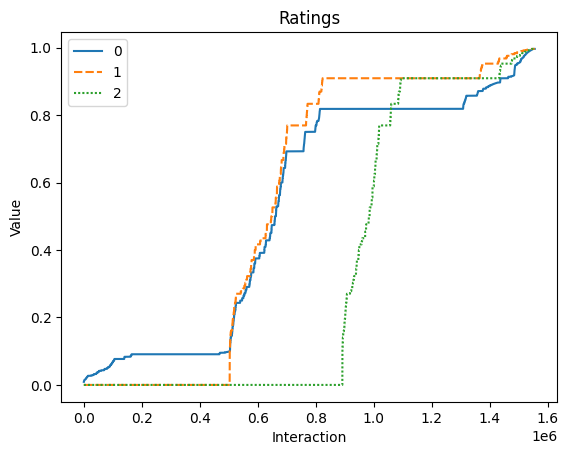

In [18]:
combined_ratings_sorted = view_details_count["combined_ratings"].copy().values
combined_ratings_sorted.sort()
views_ratings_sorted = view_details_count["views_ratings"].copy().values
views_ratings_sorted.sort()
details_ratings_sorted = view_details_count["details_ratings"].copy().values
details_ratings_sorted.sort()
plt.title("Ratings")
plt.xlabel("Interaction")
plt.ylabel("Value")
sns.lineplot(data = [combined_ratings_sorted, views_ratings_sorted, details_ratings_sorted])
plt.show()

In [19]:
view_details_count

,user_id,item_id,views_count,details_count,length,feature_id,views_ratio,details_ratio,views_ratings,details_ratings,combined_ratings
0,0,21,3.0,9.0,27.0,4,0.004444,0.013333,0.526316,0.769231,0.550607
1,0,124,1.0,0.0,3.0,1,0.013333,0.000000,0.769231,0.000000,0.692308
2,0,808,1.0,0.0,1.0,1,0.040000,0.000000,0.909091,0.000000,0.818182
3,0,1326,1.0,3.0,3.0,1,0.013333,0.040000,0.769231,0.909091,0.783217
4,0,1995,1.0,2.0,17.0,4,0.002353,0.004706,0.370370,0.540541,0.387387
...,...,...,...,...,...,...,...,...,...,...,...
1554635,41628,11228,0.0,1.0,30.0,4,0.000000,0.001333,0.000000,0.250000,0.025000
1554636,41628,15033,0.0,1.0,1.0,3,0.000000,0.040000,0.000000,0.909091,0.090909
1554637,41628,15181,0.0,1.0,8.0,4,0.000000,0.005000,0.000000,0.555556,0.055556
1554638,41628,20896,0.0,1.0,1.0,1,0.000000,0.040000,0.000000,0.909091,0.090909


In [20]:
from sklearn.model_selection import train_test_split

view_details_count_train, view_details_count_val = train_test_split(
    view_details_count,
    test_size=0.15,
    shuffle=True,
    stratify=view_details_count["user_id"],
)

print(len(view_details_count_train.loc[view_details_count_train["user_id"] == 1000]["item_id"]))
print(len(view_details_count_val.loc[view_details_count_val["user_id"] == 1000]["item_id"]))

25
4


From DataFrame to COO Matrix:

In [24]:
print(view_details_count_train["combined_ratings"].values.dtype)

float64


In [23]:
URM_combined_all = sps.coo_matrix(
    (
        view_details_count["combined_ratings"].values,
        (view_details_count["user_id"].values, view_details_count["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_combined_train = sps.coo_matrix(
    (
        view_details_count_train["combined_ratings"].values,
        (view_details_count_train["user_id"].values, view_details_count_train["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_combined_val = sps.coo_matrix(
    (
        view_details_count_val["combined_ratings"].values,
        (view_details_count_val["user_id"].values, view_details_count_val["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)

In [62]:
URM_views_all = sps.coo_matrix(
    (
        view_details_count["views_ratings"].values,
        (view_details_count["user_id"].values, view_details_count["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_views_train = sps.coo_matrix(
    (
        view_details_count_train["views_ratings"].values,
        (view_details_count_train["user_id"].values, view_details_count_train["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_views_val = sps.coo_matrix(
    (
        view_details_count_val["views_ratings"].values,
        (view_details_count_val["user_id"].values, view_details_count_val["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)

URM_details_all = sps.coo_matrix(
    (
        view_details_count["details_ratings"].values,
        (view_details_count["user_id"].values, view_details_count["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_details_train = sps.coo_matrix(
    (
        view_details_count_train["details_ratings"].values,
        (view_details_count_train["user_id"].values, view_details_count_train["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)
URM_details_val = sps.coo_matrix(
    (
        view_details_count_val["details_ratings"].values,
        (view_details_count_val["user_id"].values, view_details_count_val["item_id"].values),
    ),
    shape=(view_details_count["user_id"].nunique(), view_details_count["item_id"].nunique())
)

Save to files:

In [63]:
if not os.path.exists("Data/URM"):
    os.makedirs("Data/URM")
if not os.path.exists("Data/URM/combined"):
    os.makedirs("Data/URM/combined")
if not os.path.exists("Data/URM/details"):
    os.makedirs("Data/URM/details")
if not os.path.exists("Data/URM/views"):
    os.makedirs("Data/URM/views")

sps.save_npz('Data/URM/combined/URM_combined_all.npz', URM_combined_all)
sps.save_npz('Data/URM/combined/URM_combined_train.npz', URM_combined_train)
sps.save_npz('Data/URM/combined/URM_combined_val.npz', URM_combined_val)

sps.save_npz('Data/URM/views/URM_views_all.npz', URM_views_all)
sps.save_npz('Data/URM/views/URM_views_train.npz', URM_views_train)
sps.save_npz('Data/URM/views/URM_views_val.npz', URM_views_val)

sps.save_npz('Data/URM/details/URM_details_all.npz', URM_details_all)
sps.save_npz('Data/URM/details/URM_details_train.npz', URM_details_train)
sps.save_npz('Data/URM/details/URM_details_val.npz', URM_details_val)